# Laboratorio 5: Monte Carlo

**Universidad del Valle de Guatemala**  
**Facultad de Ingeniería**  
**Departamento de Ciencias de la Computación**  
**Aprendizaje por Refuerzo** 

## Integrantes
- Diego Leiva - 21752 
- Pablo Orellana - 21970

## Librerias

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt

## Utils

In [2]:
def set_seed(seed):
    """
    Set the random seed for reproducibility.

    Args:
        seed (int): The random seed.
    """
    np.random.seed(seed)
    random.seed(seed)

## Control Monte Carlo

In [3]:
def epsilon_greedy_policy(Q, state, nA, epsilon):
    # Check if state is in Q
    if state not in Q:
        return np.random.choice(nA) # It is not in Q, explore the action space

    q = Q[state] # Get the action-value function for the current state

    # Break ties by selecting a random action among the best actions
    best_actions = np.argwhere(q == np.max(q)).ravel()
    best_action = np.random.choice(best_actions)

    # Once we have a best action, we can use it
    # Check if we should explore
    if np.random.rand() < epsilon:
        return np.random.choice(nA) # Explore the action space
    
    return int(best_action) # Exploit the best action

In [4]:
def mc_control_first_visit(num_episodes=10000, 
                   gamma=1.0, 
                   epsilon_start=1.0,
                   epsilon_end=0.05,
                   epsilon_decay=0.7,
                   sab=True,
                   seed=42):
    """
    Monte Carlo First Visit Control for Blackjack.
    A method for estimating the value of each state-action pair in a reinforcement learning environment.

    Args:
        num_episodes (int): The number of episodes to run.
        gamma (float): The discount factor.
        epsilon_start (float): The initial exploration rate.
        epsilon_end (float): The minimum exploration rate.
        epsilon_decay (float): The decay rate of exploration.
        sab (bool): Whether to use the standard action space or the simplified action space.
        seed (int): The random seed for reproducibility.

    Returns:
        policy (dict): The learned policy.
        Q (dict): The state-action value function.
    """

    # Deterministic seed
    set_seed(seed)
    
    # Create environment Blackjack
    env = gym.make('Blackjack-v1', sab=sab)
    nA = env.action_space.n # Number of actions: 0=stick, 1=hit

    # Initialize Q-value function
    Q = defaultdict(lambda: np.zeros(nA))
    returns_sum = defaultdict(lambda: np.zeros(nA)) # Sum of returns
    returns_count = defaultdict(lambda: np.zeros(nA, dtype=int)) # Count of returns

    
    # Policy ε-soft
    def get_epsilon(ep):
        # Linearly decaying epsilon
        T = int(num_episodes * epsilon_decay)

        # Check if we are still in the decay period
        if ep < T:
            return epsilon_start - (epsilon_start - epsilon_end) * (ep / T)
        return epsilon_end # Otherwise, return the minimum epsilon
    
    # Iterate over episodes
    for ep in range(num_episodes):
        epsilon = get_epsilon(ep)

        # Generate an episode
        state, _ = env.reset(seed=seed+ep) # Reset the environment
        episode = [] # Initialize episode
        terminal = False
        truncated = False

        # Loop until terminal or truncated
        while not (terminal or truncated):
            action = epsilon_greedy_policy(Q, state, nA, epsilon) # Select action with ε-soft policy
            next_state, reward, terminal, truncated, _ = env.step(action) # Take action with the environment
            episode.append((state, action, reward)) # Store state, action, reward
            state = next_state # Update state

        # First visit MC update
        G = 0.0 # Initialize return
        visited = set() # Track visited state-action pairs
        # Iterate over episode in reverse
        for t in reversed(range(len(episode))):
            s, a, r = episode[t] # Unpack state, action, reward
            G = gamma  * G + r # Update return

            # Check if state-action pair is visited
            if (s, a) not in visited:  
                visited.add((s, a)) # Mark state-action pair as visited
                returns_count[s][a] += 1 # Increment count of returns
                returns_sum[s][a] += G  # Increment sum of returns
                Q[s][a] = returns_sum[s][a] / returns_count[s][a] # Update Q-value

    # Final Policy definition
    policy = {}
    for s in Q:
        q = Q[s] # Get the action-value function for the current state
        best_actions = np.argwhere(q == np.max(q)).ravel() # Get the best actions
        policy[s] = int(np.random.choice(best_actions)) # Randomly select one of the best actions

    env.close() # Close the environment
    return policy, Q


## Evaluacion de Politica

In [5]:
def evaluate_policy(policy, Q, num_episodes=10000, sab=True, seed=42):
    # Deterministic seed
    set_seed(seed)

    # Create environment Blackjack
    env = gym.make('Blackjack-v1', sab=sab)

    nA = env.action_space.n  # Number of actions: 0=stick, 1=hit
    rewards = []  # List to store rewards

    # Iterate over episodes
    for ep in range(num_episodes):
        state, _ = env.reset(seed=seed+ep)  # Reset the environment
        done = False   # Whether the episode is done
        total_reward = 0  # Initialize total reward for the episode

        # Loop until the episode is done
        while not done:
            # Ensure there
            if state in policy:
                action = policy[state]  # Get action from policy
            elif state in Q:
                q = Q[state]  # Get action-value function for the current state
                best_actions = np.argwhere(q == np.max(q)).ravel()
                action = int(np.random.choice(best_actions))  # Break ties randomly
            else:
                # Fallback to a default action if state is not in policy or Q
                ps = state[0] 
                action = 0 if ps >= 20 else 1

            next_state, reward, done, truncated, _ = env.step(action)  # Take action with the environment
            total_reward += reward  # Update total reward
            done = done or truncated  # Check if the episode is done
            state = next_state  # Update state
            
        rewards.append(total_reward)  # Store total reward for the episode
    
    env.close()  # Close the environment

    # Compute mean and standard error of rewards
    return float(np.mean(rewards)), float(np.std(rewards)/np.sqrt(num_episodes))

## Visualizaciones

In [6]:
def plot_policy_heatmap(policy, Q=None, usable_ace=False, title="Policy"):
    # Define grid for heatmap
    grid = np.zeros((10, 10), dtype=int)

    # Fill grid with actions based on policy or Q-values
    # Dealer showing Ace is represented as 1, and 10 as 10
    # Player sum ranges from 12 to 21 (inclusive)
    # Dealer showing ranges from Ace (1) to 10 (10)
    for ps in range(12, 22):
        for dc in range(1, 11):
            s = (ps, dc, usable_ace)
            if s in policy:
                a = policy[s]
            elif Q is not None and s in Q:
                q = Q[s]
                best = np.argwhere(q == np.max(q)).ravel()
                a = int(np.random.choice(best))
            else:
                a = 0 if ps >= 20 else 1
            grid[dc-1, ps-12] = a

    # Plot heatmap
    plt.figure(figsize=(6,5))
    plt.imshow(grid[::-1], vmin=0, vmax=1)
    plt.title(f"{title}")
    plt.xlabel("Player sum (12..21)")
    plt.ylabel("Dealer showing (A..10)")
    plt.xticks(range(0,10), range(12,22))
    plt.yticks(range(0,10), list(reversed(["A"]+list(range(2,11)))))
    plt.colorbar(ticks=[0,1], label="0=Stick, 1=Hit")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


## Random Agent

In [7]:
def benchmark_random(num_episodes=100000, sab=True, seed=999):
    env = gym.make("Blackjack-v1", sab=sab)
    np.random.seed(seed); random.seed(seed)
    rewards=[]
    for ep in range(num_episodes):
        s,_ = env.reset(seed=seed+ep); done=False; tot=0
        while not done:
            a = env.action_space.sample()
            s,r,term,trun,_ = env.step(a)
            tot += r; done = term or trun
        rewards.append(tot)
    env.close()
    return float(np.mean(rewards)), float(np.std(rewards)/np.sqrt(num_episodes))

In [8]:

def eval_details(policy, Q, num_episodes=100000, sab=True, seed=123):
    env = gym.make("Blackjack-v1", sab=sab)
    wins=draws=loss=0
    for ep in range(num_episodes):
        s,_ = env.reset(seed=seed+ep); done=False; tot=0
        while not done:
            if s in policy: a = policy[s]
            elif s in Q: a = int(np.argmax(Q[s]))
            else: a = 0 if s[0] >= 20 else 1
            s,r,term,trun,_ = env.step(a)
            done = term or trun; tot += r
        if tot>0: wins+=1
        elif tot==0: draws+=1
        else: loss+=1
    env.close()
    return wins/num_episodes, draws/num_episodes, loss/num_episodes

## Ejecucion

In [9]:
# Train agent using Monte Carlo Control First-Visit
policy, Q = mc_control_first_visit(num_episodes=300000,epsilon_end=0.1, epsilon_decay=0.98)

In [10]:
# Evaluate policy
mean_reward, std_reward = evaluate_policy(policy, Q, num_episodes=100000)
print("Monte carlo Performance:")
print(f"\t- Mean reward: {mean_reward}\n\t- Std reward: {std_reward}")

Monte carlo Performance:
	- Mean reward: -0.06658
	- Std reward: 0.0030387285229187557


In [11]:
print("Random Performance:", benchmark_random(sab=True))
w,d,l = eval_details(policy, Q, num_episodes=100000, sab=True)
print(f"Win/Draw/Loss: {w:.3f} / {d:.3f} / {l:.3f}")

Random Performance: (-0.39348, 0.0028356189617083603)
Win/Draw/Loss: 0.431 / 0.072 / 0.497


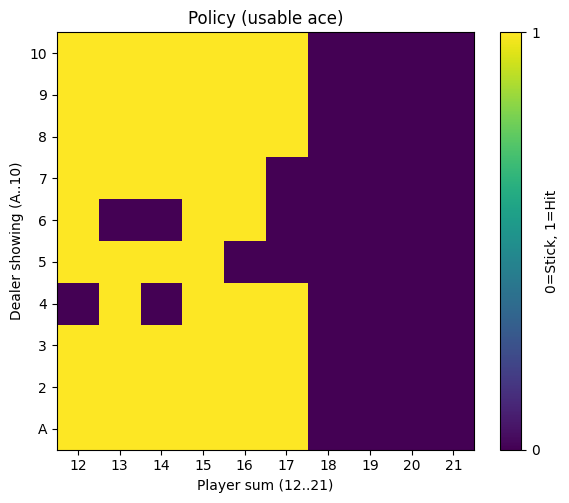

In [12]:
# Plot policy heatmap
plot_policy_heatmap(policy, usable_ace=True,  title="Policy (usable ace)")

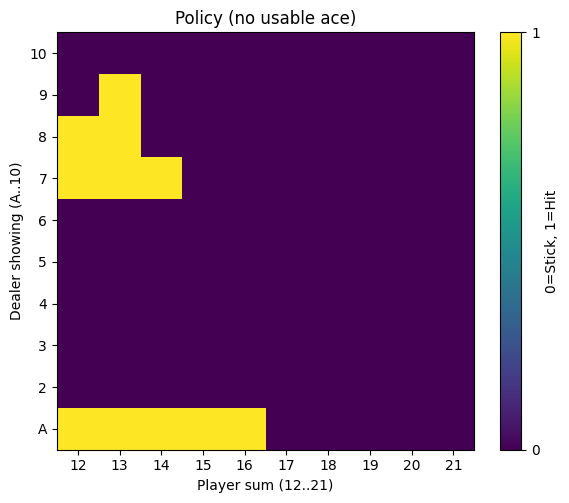

In [13]:
plot_policy_heatmap(policy, usable_ace=False, title="Policy (no usable ace)")